# Topic Modelling using Non-Negative Matrix Factorization 

In [58]:
import eland as ed
from eland.conftest import *
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim import corpora, models
from wordcloud import WordCloud
import gensim
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from pprint import pprint
import re
import warnings
warnings.filterwarnings('ignore')

## Importing data from Elasticsearch

In [2]:
ed_df = ed.DataFrame('localhost', 'twitter', columns=['full_text_processed'])

# defining the full-text query we need: Retrieving records for full_text_processed with the condition is_retweet=False and is_quote_status=False
query_unique = {
    "bool": {
        "must": {
            "term":{"is_retweet":"false"},
        },
        "filter": {
            "term":{"is_quote_status":"false"}
        },
    }
}
# using full-text search capabilities with Eland:
df_ed = ed_df.es_query(query_unique)
df_tweets = df_ed.to_pandas()

In [3]:
df_tweets.head()

,full_text_processed
1262754556456271872,proactive plan pm narendra modi take stock cyc...
1262754552505184256,odisha bengal ha amphan last 2 day
1262754542589861888,many test given human race corona ampan
1262754528979345408,latest release indian meteorological departmen...
1262746620736598016,visit principal secretary govtcommerce amptran...


### Tokenising and removing short tweets (less than 4 words)

In [4]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [5]:
df_tweets['full_text_processed'] = df_tweets['full_text_processed'].apply(lambda x: remove_emoji(x))
df_tweets['full_text_tokens'] = df_tweets['full_text_processed'].apply(lambda x: [w for w in x.split()])
df_tweets['length'] = df_tweets['full_text_tokens'].apply(lambda x: len(x))
df_tweets = df_tweets[df_tweets['length']>4]

In [32]:
stop_words = stopwords.words('english')
stop_words.extend(['from','not', 'would', 'say', 'could', '_', 'be', 'go', 'do', 'rather', 'seem', 'due', 'via', 'done', 'said'])

tweets = df_tweets.full_text_processed.to_list()


## Building the Vectorizer

In [35]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(2,4), stop_words=stop_words, min_df=5, token_pattern='(?u)\\b[^\\s|\\.]+\\b')

In [36]:
# Create the TF-IDF matrix
tweets_tfidf = vectorizer.fit_transform(tweets)
tweets_tfidf.shape

(95337, 79597)

In [37]:
# Tokenize the documents according to the parameters in the vectorizer
for i in range(len(tweets)):
    tweets[i] = vectorizer.build_analyzer()(tweets[i])

In [41]:
# Create a dictionary and corpus for Gensim to compute coherence metrics
dictionary=corpora.Dictionary(tweets)
corpus=[dictionary.doc2bow(doc) for doc in tweets]
# Adding the TF-IDF for better insight 
tfidf = gensim.models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

## Methods for Analysis

In [75]:
# Function to join words
def combine_ngrams(tokens):
    return ['_'.join(token.split()) for token in tokens]

# Function that prints the top words of a topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        message += " ".join(combine_ngrams(words))
        print(message)
        print('\n')

# Function that prints the topics as a list
def get_topics(model, feature_names, n_top_words, n_components):
    topics=list(range(n_components))
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx]=[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics

# Function that returns the optimal number of topics based on coherence
def find_best_models(tfidf, vectorizer, corpus, dictionary, max_num_topics=12, n_words=15):
    coherence = []
    for k in range(4, max_num_topics+1):
        nmf = NMF(n_components=k, random_state=1, max_iter=10000).fit(tfidf)
        topics = get_topics(nmf, vectorizer.get_feature_names(), n_words, k)
        score = models.coherencemodel.CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence.append(score.get_coherence())
    
    # A plot of coherence the number of topics
    fig, ax = plt.subplots(1,1)
    ax.plot(np.array(list(range(len(coherence))))+2, coherence, '+-')
    ax.set_xlabel('Number of Topics')
    ax.set_ylabel('Coherence')
    ax.set_title('UMass Coherence')
    return np.array(coherence).argsort()[-3:][::-1]+2

# Function to create wordclouds and save things
def create_wordcloud(words, name):
    # Create images directory if it doesn't exist
    if os.path.isdir('../reports/figures/topic_model_images/') == False:
        os.system('mkdir ../reports/figures/topic_model_images/')
    # creating wordcloud figure
    words = combine_ngrams(words)
    topic = WordCloud(ranks_only=True, max_font_size=40, background_color="white", include_numbers=True, regexp=r'\b[\w*[\']*\w*[\_]*\w*]*\b').generate(' '.join(words))
    plt.figure(figsize=(10, 6))
    plt.imshow(topic, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('../reports/figures/topic_model_images/{}.png'.format(name), dpi=300) # Save figure
    plt.show()

In [54]:
# Run a preliminary model
nmf = NMF(n_components=10, random_state=1,
        beta_loss='kullback-leibler', solver='mu',
        max_iter=10000).fit(tweets_tfidf)

In [59]:
print_top_words(nmf, vectorizer.get_feature_names(), 20)

Topic #0: amphan_please affected_area cyclone_amphan_please area_cyclone area_cyclone_amphan airtel_network effort_ensure possible_effort team_making network_experiencing making_possible please_assured airtel_network_experiencing assured_team please_assured_team assured_team_making please_assured_team_making area_cyclone_amphan_please team_making_possible disruption_certain


Topic #1: cyclone_amphan live_update amphan_leaf amphan_live kolkata_airport cyclone_amphan_leaf cyclone_amphan_live amphan_ha bangladesh_india tropical_cyclone cyclone_amphan_ha affected_cyclone_amphan amphan_live_update affected_cyclone cyclone_amphan_live_update trail_destruction impact_cyclone aftermath_cyclone tropical_cyclone_amphan mamata_banerjee


Topic #2: pm_modi prime_minister bengal_odisha aerial_survey west_bengal 1000_crore narendra_modi affected_area cyclone_amfan namo_app r_1000 r_1000_crore amphan_pm amphan_affected take_stock cyclone_amphan_pm conduct_aerial conduct_aerial_survey modi_visit area

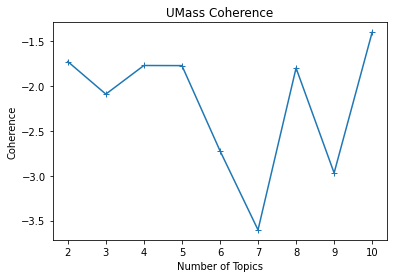

In [70]:
# Plot coherence and capture the top three models based on highest coherence
best_models = find_best_models(tweets_tfidf, vectorizer, corpus, dictionary, max_num_topics=12)

In [72]:
# Print topics for the best models
for k in best_models:
    nmf = NMF(n_components=k, random_state=1, max_iter=10000).fit(tweets_tfidf)
    print(f'NMF model: number of topics = {k}')
    print('-----------------------')
    print_top_words(nmf, vectorizer.get_feature_names(), 20)

NMF model: number of topics = 10
-----------------------
Topic #0: please_assured network_experiencing please_assured_team assured_team airtel_network_experiencing team_making possible_effort airtel_network assured_team_making please_assured_team_making disruption_certain team_making_possible amphan_please_assured making_possible assured_team_making_possible amphan_please_assured_team experiencing_disruption_certain network_experiencing_disruption_certain experiencing_disruption network_experiencing_disruption


Topic #1: cyclone_amphan super_cyclone super_cyclone_amphan india_bangladesh amphan_hit cyclone_amphan_hit amphan_live cyclone_amphan_live live_update amphan_leaf cyclone_amphan_leaf amphan_live_update cyclone_amphan_live_update bangladesh_india cyclone_amphan_ha amphan_ha affected_cyclone_amphan hit_india amphan_india cyclone_amphan_india


Topic #2: aerial_survey survey_affected survey_affected_area aerial_survey_affected aerial_survey_affected_area affected_area_bengal area_

Topic 1


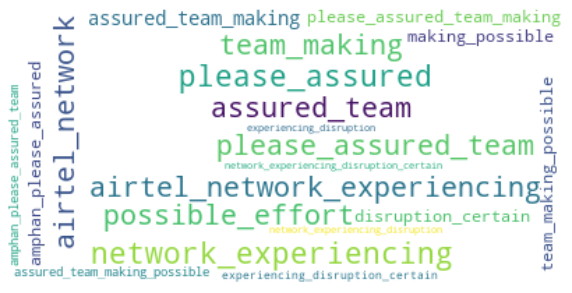

Topic 2


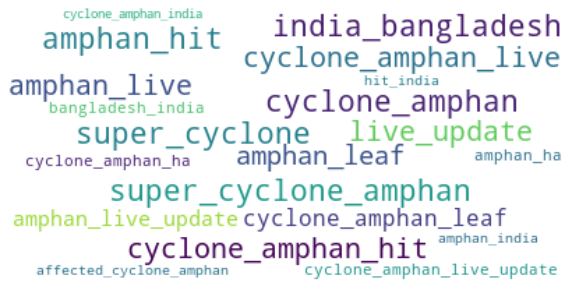

Topic 3


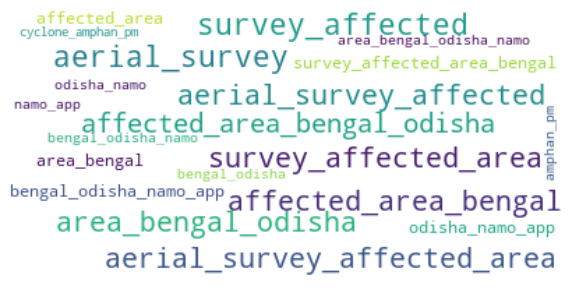

Topic 4


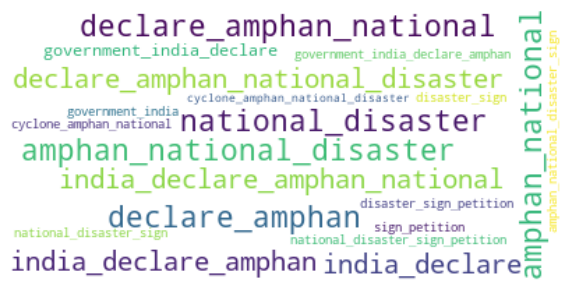

Topic 5


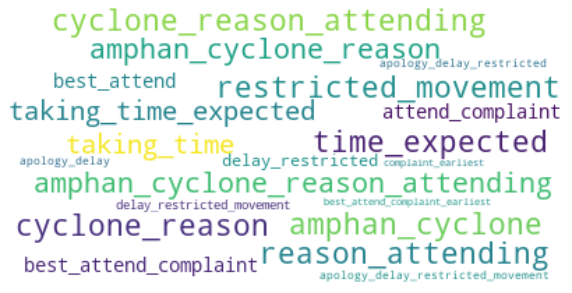

Topic 6


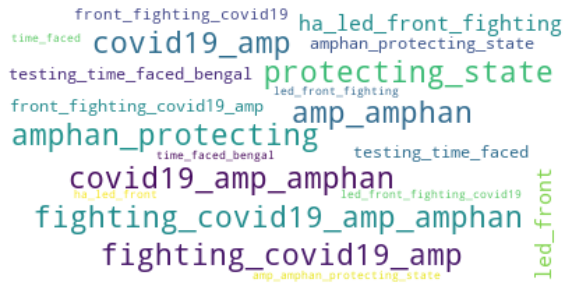

Topic 7


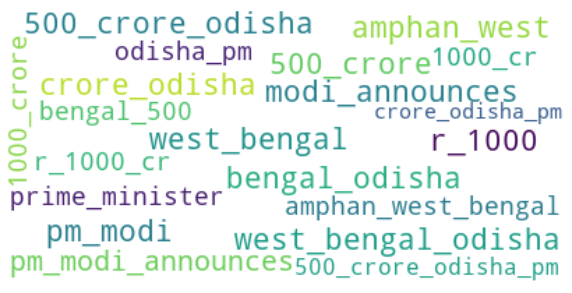

Topic 8


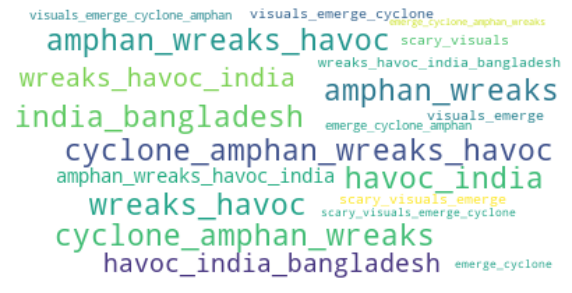

Topic 9


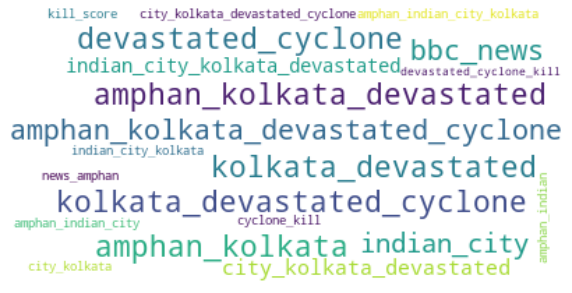

Topic 10


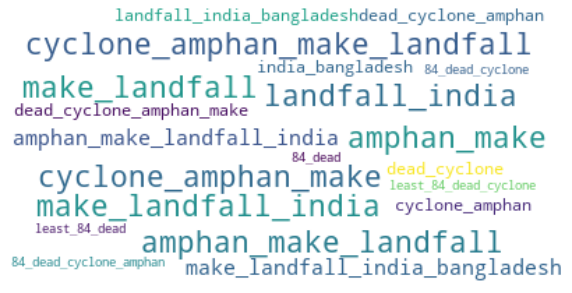

In [76]:
# Wordclouds for topics
nmf = NMF(n_components=best_models[0], random_state=1, max_iter=10000).fit(tweets_tfidf)
best_topics = get_topics(nmf, vectorizer.get_feature_names(), 20, best_models[0])

for k, topic in enumerate(best_topics):
    print(f'Topic {k+1}')
    create_wordcloud(topic, f'hwf_nmf_topic{k+1}')
